In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [17]:
def get_cone_2d_location(bin_im):
    row_sum = np.sum(bin_im, axis=1)
    i = 0

    while row_sum[i] > 1 and i < 799:
        bin_im[i, :] = np.zeros(848)
        i += 1

    airrow = 0
    for row_idx in range(799):
        if row_sum[row_idx] > 400 * 255:
            airrow = row_idx
    bin_im[1:airrow, :] = 0
    row_sum = np.sum(bin_im, axis=1)
    cone_found = False
    cone_row = 0
    max_row = 0
    row = 799  # start where no drone parts are visible in image
    cone_started = False
    while not cone_found and row >= 0:
        if row_sum[row] >= max_row and row_sum[row] > 4 * 255:
            cone_row = row
            max_row = row_sum[row]
            cone_started = True
        elif cone_started:
            cone_found = True
        row -= 1

    current_start = 0
    max_start = 0
    max_width = 0
    current_width = 0
    for col_index in range(847):
        if bin_im[cone_row, col_index] == 0:
            if current_width > max_width:
                max_width = current_width
                max_start = current_start
            current_width = 0
            current_start = 0
        else:
            if current_start == 0:
                current_start = col_index
            current_width += 1
    return [max_start + int(np.ceil(max_width / 2)) - 424, -cone_row + 400, max_width]

In [48]:
def get_cone_3d_location(cone_width_px, cone_width_m, conetop_coor, tune_factor):
    x_cor = 0
    y_cor = 0
    z_cor = -1  # do not update if z remains -1 TODO
    if cone_width_px > 0:  # only updates when cone detected
        # position relative to the camera in meters.
        z_cor = cone_width_m * tune_factor / cone_width_px
        x_cor = conetop_coor[0] * z_cor / tune_factor
        y_cor = conetop_coor[1] * z_cor / tune_factor
    return np.array([z_cor, -x_cor, y_cor])

[-211, -209, 31]
9
1.425745806451613
[-158, -399, 25]
19
1.7892400000000002
[409, -201, 1]
29
87.55939
[221, -316, 23]
35
1.4715034782608698
[-285, 48, 8]
36
9.214739999999999
[-284, 204, 14]
46
3.892711428571429
[-207, -322, 31]
81
1.340415806451613
[292, 76, 8]
84
8.375820000000001
[-313, 98, 8]
123
8.2088
[-176, 18, 9]
140
7.1699
[287, -215, 31]
162
1.155835806451613
[383, 76, 14]
165
2.315011428571429
[93, -399, 23]
188
2.3190434782608698
[396, -287, 23]
193
1.7966334782608695
[-35, -245, 25]
199
1.49357


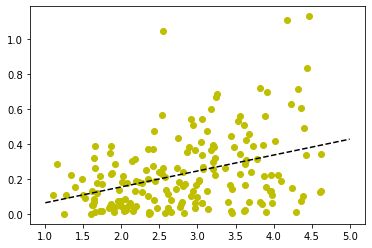

In [96]:
text_file_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted/data_collection_gazebo/raw_data/21-05-12_12-05-55/action.data'
image_base_path = '/media/thomas/Elements/experimental_data/model_evaluation_handcrafted/data_collection_gazebo/raw_data/21-05-12_12-05-55/observation/'
error_x = []
nb_images = 200
tune_factor = 500
distance_x = []
with open(text_file_path) as f:
    for image_idx in range(nb_images):
        ground_truth = f.readline().split()[2:5]
        ground_truth_np = np.array([float(ground_truth[0]),float(ground_truth[1]),float(ground_truth[2])])
        
        #print(ground_truth_np)
        image_path = image_base_path+str(image_idx).zfill(15)+'.jpg'
        image = cv2.imread(image_path,-1)
        #plt.imshow(image,cmap='gray',vmax=255,vmin=0)
        image_coord = get_cone_2d_location(image)
        world_coor = get_cone_3d_location(image_coord[2],0.18,image_coord[0:2],tune_factor)
        #print(world_coor)
        current_error = abs(np.subtract(world_coor[0],ground_truth_np[0]))
        if current_error>.5*ground_truth_np[0]:
            print(image_coord)
            print(image_idx)
            print(current_error)
        else:
            distance_x.append(ground_truth_np[0])
            error_x.append(current_error)
        #print(error)
gradient,intercept = np.polyfit(distance_x,error_x,1)
poly1d_fn = np.poly1d(coef)
x1=np.linspace(1,5,500)
y1=gradient*x1+intercept
plt.plot(distance_x,error_x,'yo', x1, y1, '--k')